<a href="https://colab.research.google.com/github/ArghaSarker/reinforcement-learning-homework-summer-2023/blob/main/GridWorld(Silvie).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Examples of Grid Worlds
- default grid world in implementation is similar to this grid world: https://medium.com/@ngao7/markov-decision-process-basics-3da5144d3348
- great visualization: https://cs.stanford.edu/people/karpathy/reinforcejs/gridworld_dp.html
- more complex grid world (different trap strengths, teleporting tile): https://neptune.ai/blog/markov-decision-process-in-reinforcement-learning

#Implementation
General information:
- number of states is set by world size - number of wall tiles
- amount of trap tiles and wall tiles can be customized
- 4 actions: up, down, left, right
- 2 end states (good/bad) -> good state is goal state
- static/non-probabilisitc rewards: non-special tile (-1), trap tile (-10), bad end (-100), good end (+100) 
  - probabilistic state transition function: chosen action (p=0.7), unwanted action (each p=0.1)
- when **_choosing_** an action, we automatically **exclude impossible actions** (i.e. actions against world boundary or wall tile). However, when **_conducting_** an action with probabilistic state transition function, the agent could do **any actions** with a certain probability (i.e. **also impossible ones** -> agent runs into boundary/wall and therefore stays in current tile)


Complexities to overcome:
- avoid running into wall (non-passible tile + world boundary)
- avoid running into trap (penalizing tile)
- avoid bad end (penalizing tile)
- choose good end (rewarding tile)
- terminate as quickly as possible (each step to non-special tile is penalized)

Default Grid World:
- 12 tiles - 11 accessible / 1 unacessible (wall)
- 11 states: {(0,0),(1,0),(2,0),(0,1),(2,1),(0,2),(1,2),(2,2),(0,3),(1,3),(2,3)}
  - 4 special states: 2 end states (good/bad), 1 trap state

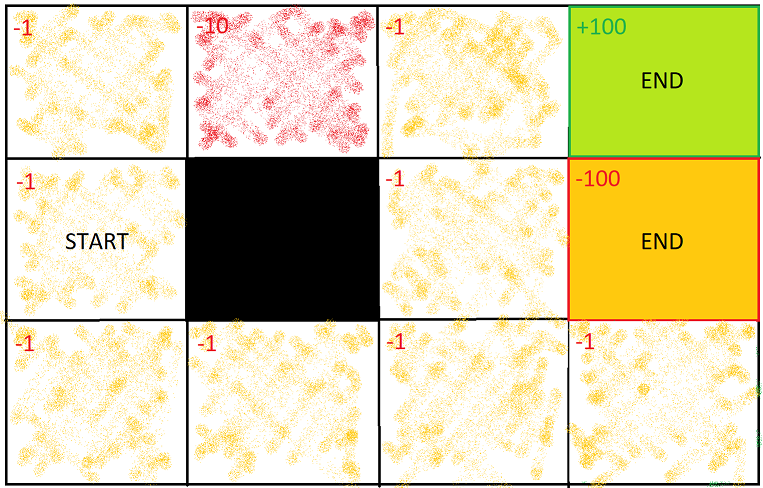

**NOTE**

In this implementation, the policy does not get optimized. Also, the policy prefers those actions that lead to states that are closer to the "good" goal state. So, the agent always wants to move according to **shortest distance** to "good" goal, and NOT according to the actual rewards/return. 

Therefore, in the default example, the agent will choose the suboptimal way (i.e. going through the trap) rather than the longer but trap-free way.

In [6]:
import math
import random
import numpy as np
import matplotlib.pyplot as plt 

In [20]:
class GridWorld:

  def __init__(self, n_rows=3, n_cols=4, win_state=(0,3), lose_state=(1,3), walls=[(1,1)], traps=[(0,1)], start=(1,0)):
    """
      Creates a grid world of 
        - (n_rows x n_cols)- len(wall) states 
        - len(walls) non-passable wall tiles
        - len(traps) trap tiles that penalize
        - 2 goal states (good=win_state, bad=lose_state) that end current episode and reset environment
      Sets start position of agent (start) 
    """
    self.n_rows = n_rows
    self.n_cols = n_cols
    self.win_state = win_state
    self.lose_state = lose_state
    self.walls = walls
    self.traps = traps
    self.start = start
    self.pos_agent = start
  

  def get_actions(self):
    """
      Checks if actions in current state are restricted and returns list of all possible actions
    """
    up = (-1,0)
    down = (1,0)
    right = (0,1)
    left = (0,-1)

    #check if agent is on boundary tile
    #upper boundary
    if self.pos_agent[0] == 0:
      #upper left corner
      if self.pos_agent[1] == 0:
        actions = [down,right]
      #upper right corner
      elif self.pos_agent[1] == self.n_cols-1:
        actions = [down,left]
      else:
        actions = [down,left,right]
    #lower boundary
    elif self.pos_agent[0] == self.n_rows-1:
      #lower left corner
      if self.pos_agent[1] == 0:
        actions = [up,right]
      #lower right corner
      elif self.pos_agent[1] == self.n_cols-1:
        actions = [up,left]
      else:
        actions = [up,left,right]
    #left boundary
    elif self.pos_agent[1] == 0:
      actions = [up,down,right]
    #right boundary
    elif self.pos_agent[1] == self.n_cols-1:
      actions = [up,down,left]
    #no boundary
    else:
      actions = [up,down,left,right]

    #check if agent is next to a wall tile
    for wall in self.walls:
      for action in actions:
        if wall == tuple(sum(i) for i in zip(self.pos_agent,action)):
          #remove action towards wall tile
          actions.remove(action)

    #return possible actions
    return actions


  def policy(self, actions):
    """
      Computes a probability distribution over all possible actions, based on distance to good end tile.
      - actions = all possible actions that can be taken in current state
    """
    distances = []
    for action in actions:
      #get resulting state (when taking action)
      new_state = tuple(sum(i) for i in zip(self.pos_agent,action))
      #get distance to good goal state
      distance = math.sqrt((new_state[0] - self.win_state[0])**2 + (new_state[1] - self.win_state[1])**2)
      #save distance
      distances.append(distance)
    #convert distances into probabilities (lower distance = higher probability)
    inv_distances = [1/d if d != 0.0 else 1.0 for d in distances] #calculate inverse of each distance -> smaller distance has higher value
    sum_inv_distances = sum(inv_distances)       
    prob_dist = [d/sum_inv_distances for d in inv_distances]
    return prob_dist


  def choose_action(self):
    """
      Chooses an action randomly, given the policy
    """
    #get possible actions
    actions = self.get_actions()
    #get "goodness" probability distribution (policy)
    prob_dist = self.policy(actions)
    #choose action randomly based on their probability
    action = random.choices(actions, weights=prob_dist, k=1)[0] 
    return action


  def make_action(self,action):
    """
      Conducts action implicitly by changing agent's position
      - action = the chosen action
      - returns the state reached when taking the action
    """
    all_actions = [(-1,0),(1,0),(0,-1),(0,1)] #up,down,left,right
    #assign chosen action a probability of 0.7 (others p=0.1)
    probabilities = [0.7 if a == action else 0.1 for a in all_actions]
    #take action randomly based on their probability
    action = random.choices(all_actions, weights=probabilities, k=1)[0] 
    new_state = tuple(sum(i) for i in zip(self.pos_agent,action))
    #if agent runs into wall or world boundary
    if new_state in self.walls or new_state[0] < 0 or new_state[0] > self.n_rows-1 or new_state[1] < 0 or new_state[1] > self.n_cols-1:
      #stay in current position
      new_state = self.pos_agent
    #move agent to next state
    self.pos_agent = new_state
    return new_state
    

  def get_reward(self):
    """
      Add reward gained after taking an action
    """
    #check if action lead to good end tile
    if self.pos_agent == self.win_state:
      reward = 100
    #check if action lead to bad end tile
    elif self.pos_agent == self.lose_state:
      reward = -100
    #check if action lead to trap tile
    elif self.pos_agent in self.traps:
      reward = -10
    #action lead to non-special tile
    else:
      reward = -1
    #return reward
    return reward


  def game_over(self):
    """
      Returns True if end tile is reached and False if not
    """
    return self.pos_agent == self.win_state or self.pos_agent == self.lose_state


  def reset(self):
    """
      Resets the world to initialization
    """
    self.pos_agent = self.start
    


#Run Grid World

In [21]:
def monte_carlo(world,n_episodes=1000,discount_factor=1.0):
  """
    Calculates the MC-estimation of the state-value function of each state visited
    - world = GridWorld object
    - n_episodes = amount of episodes that will be conducted
  """
  value_function = [[None for column in range(world.n_cols)] for row in range(world.n_rows)]    #stores the MC-estimations for all states
  visited_states = dict() #stores states (key) with the amount of visits + return/cumulative reward (value)
  episode_info = []  #stores all info of single episode (list representing sequence of (state,action,reward))

  #agent interacts with environment in multiple episodes 
  for episode in range(n_episodes):

    #CONDUCT AN EPISODE
    #agent interacts with world until reaching end state
    while world.game_over() == False:
      #get current state
      state = world.pos_agent
      #choose action
      action = world.choose_action()
      #take action
      new_state = world.make_action(action)
      #receive reward
      reward = world.get_reward()
      #save state, action, and received reward
      episode_info.append((state,action,reward))
    #reset world when episode done
    world.reset()

    #CALCULATE RETURN G FOR ALL STATES REACHED IN EPISODE
    #initialize the return
    G = 0
    #iterate over each step in the episode in reverse order
    for t in range(len(episode_info)-1, -1, -1):
        #get the state and reward
        state, _, reward = episode_info[t]
        #add the reward to the total return
        G = discount_factor * G + reward
        #increase the count + add return for current state
        visited_states[state] = visited_states.get(state, (0,0))
        visited_states[state] = visited_states[state][0] + 1, visited_states[state][1] + G
    #reset episode info after all returns G are noted
    episode_info = []

  #CALCULATE MC-ESTIMATION OF ALL REACHED STATES (after conducting all episodes)
  for state, (n_visits, cumulative_reward) in visited_states.items():
    v = cumulative_reward/n_visits
    value_function[state[0]][state[1]] = v
  
  return value_function


In [24]:
n_episodes = 1000

#initialize world
world = GridWorld(n_rows=3, n_cols=4, win_state=(0,3), lose_state=(1,3), walls=[(1,1)], traps=[(0,1)], start=(1,0))
#evaluate policy
estimations = monte_carlo(world,n_episodes)


#Visualization

In [25]:
def visualize(world):
  """
    Visualizes the GridWorld with the MC-estimates from 50,200,500,1000 and 10000 episodes
    - world = GridWorld object
  """
  e = [50,200,500,1000,10000]
  grids = []
  for n_episodes in e:
    #create grid by evaluating policy
    grid = monte_carlo(world,n_episodes)
    #store grid
    grids.append(grid)
  
  #convert into numpy array to solve error
  grids = np.array(grids)

  #create plot
  fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(12,15))

  for i,ax in enumerate (axes.flat):

    #add subplot of the grid with a color map
    im = ax.imshow(grids[i].astype(float), cmap="coolwarm")

    # Set the tick labels to the state indices
    ax.set_xticks(np.arange(world.n_cols))
    ax.set_yticks(np.arange(world.n_rows))
    ax.set_xticklabels(np.arange(world.n_cols))
    ax.set_yticklabels(np.arange(world.n_rows))

    # Rotate the tick labels and set their alignment
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
            rotation_mode="anchor")

    # Loop over data dimensions and create text annotations
    for m in range(world.n_rows):
        for n in range(world.n_cols):
            value = grids[i][m, n]
            if value==None:
                text = "None"
            else:
                text = "{:.2f}".format(value)
            ax.text(n, m, text, ha="center", va="center", color="w")

    # Add a color bar
    cbar = ax.figure.colorbar(im, ax=ax)
    cbar.ax.set_ylabel("Value", rotation=-90, va="bottom")

    # Set the title of the plot
    ax.set_title(f"Value Function after {e[i]} episodes")

  # Adjust padding around the figure
  plt.tight_layout()

  # Show the plot
  plt.show()


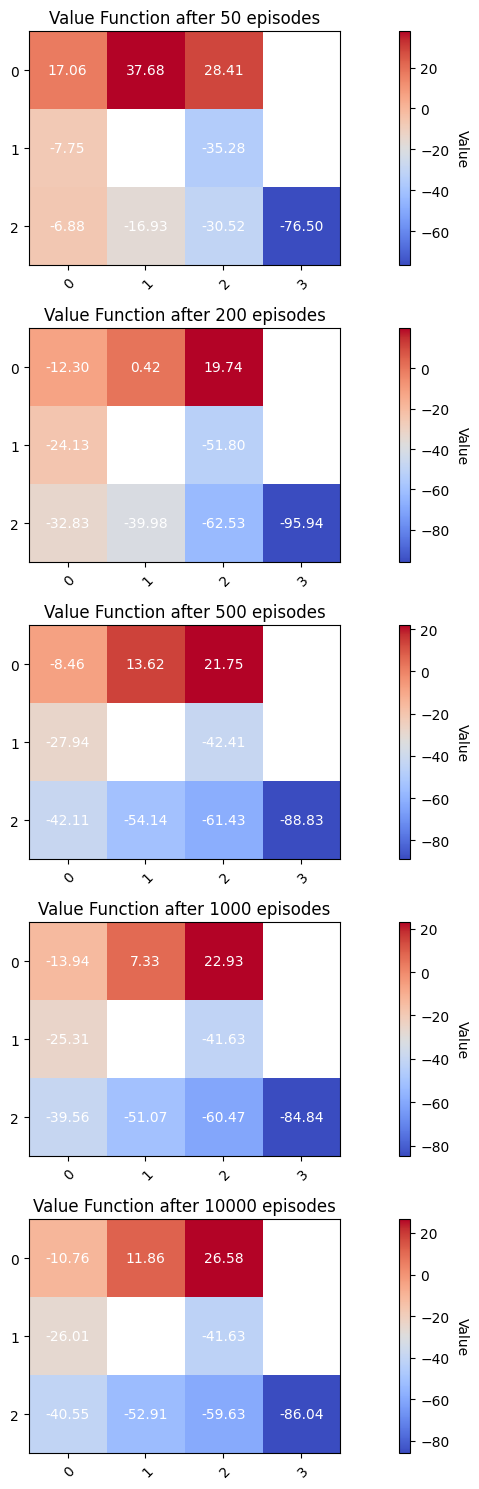

In [26]:
visualize(world)

The "good" path is estimated worse because of our policy. Since our policy prefers taking actions that lead to states close to the "good" goal state, we will be likely to end up in the "bad" end when coming from the lower path. Again, this is because when deciding on an action in state (1,2) the policy considers the actions "up" and "right" equally good. Therefore, there is a very high probability that we end up in the bad end state (a higher probability compared to coming from state (0,2)).